# **Rough Overview of Train.py**

This file is designed to provide a quick guide for users navigating the train.py file, which can be found in the [original work](https://github.com/sbasu276/GBCNet/blob/main/train.py).

## **Startup Code**

We start by importing the required libraries.

In [15]:
# Basic Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR

# Custom Imports
import transforms as T  # Custom transformations module
import utils  # Utility functions module
from dataloader import GbDataset, GbRawDataset, GbCropDataset  # Custom dataset loaders
from models import GbcNet  # Custom neural network model

# Other
import argparse
import os
import json
import copy
import neptune.new as neptune
import seaborn as sns
from __future__ import print_function, division
from skimage import io, transform
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score



# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

We'll also define a device variable to make our code flexible, enabling it to run on both GPU and CPU.

In [3]:
# Determine device (CPU or GPU) for computation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Since we'll be working within a notebook instead of executing the original train.py file from the command line, there's no need to include the parser method. This also means that we'll need to hardcode some values in the following segments, as we won't be providing them through the command line or default values.

## **I - Data Digestion**

#### **1. Loading in the Dataset**

**Defining the Image Transformation**

First, we define the image transformations to be applied to the images in our dataset.

In [4]:
# Initialize a list to store transformations
transforms = []

# Add resizing transformation to the list
transforms.append(T.Resize((224, 224)))

# Uncomment the line below to add random horizontal flip transformation with probability 0.25
# transforms.append(T.RandomHorizontalFlip(0.25))

# Add tensor conversion transformation to the list
transforms.append(T.ToTensor())

# Combine all transformations into a single composition
img_transforms = T.Compose(transforms)

# Define validation transformations using a composition
val_transforms = T.Compose([
    T.Resize((224, 224)),  # Resize images
    T.ToTensor()  # Convert images to tensors
])

**Loading the Dataset**

In [5]:
# Open and load the metadata file
with open("data/roi_pred.json", "r") as f:
    df = json.load(f)

# Initialize lists to store training and validation labels
train_labels = []
val_labels = []

# Read and store training labels
train_file_path = os.path.join("data", "train.txt")
with open(train_file_path, "r") as f:
    for line in f.readlines():
        train_labels.append(line.strip())

# Read and store validation labels
val_file_path = os.path.join("data", "test.txt")
with open(val_file_path, "r") as f:
    for line in f.readlines():
        val_labels.append(line.strip())

#### **2. Preliminary Analysis**

**Visualizing the Dataset**

Let's plot a few random images of the training data and highlight the gallbladder.

According to the paper, the images are labeled as either 0, 1, or 2, referring to normal, benign, and malignant, respectively. Let's create a convenience function for this mapping.

In [6]:
# Function to get the class label name based on class index
def get_class_label(class_index):
    if class_index == 0:
        return "Normal"
    elif class_index == 1:
        return "Benign"
    elif class_index == 2:
        return "Malignant"
    else:
        return "Unknown"

Now, let's read and display a few of our images along with the ground truth ROI. This is the area where the gall bladder resides, and where the model should classify as either normal, benign, or malignant.

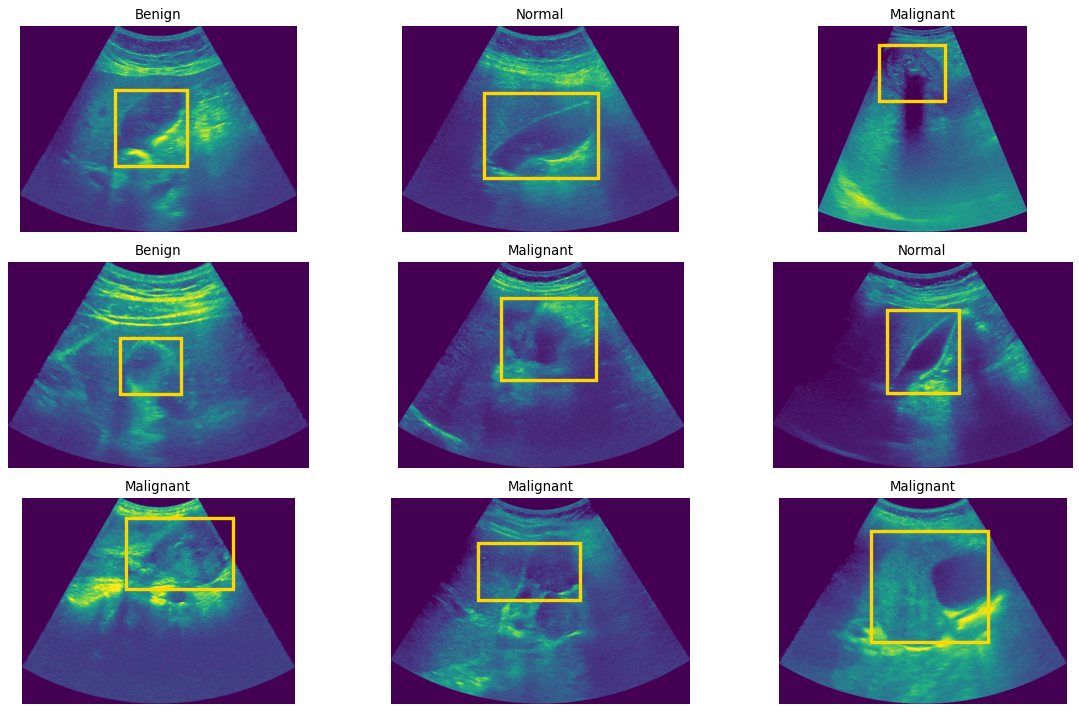

In [7]:
# Open and load the metadata file
with open("data/roi_pred.json", "r") as f:
    df = json.load(f)

# Function to plot images with bounding boxes
def plot_images_with_boxes(train_labels, df):
    plt.figure(figsize=(15, 9))
    for i in range(9):
        # Choose a random index
        random_index = random.randint(0, len(train_labels) - 1)
        img_name, img_class = train_labels[random_index][:11], train_labels[random_index][-1]

        # Load the image
        img = plt.imread('./data/imgs/' + img_name)

        # Plot the image
        plt.subplot(3, 3, i+1)
        plt.imshow(img)
        plt.title(get_class_label(int(img_class)))
        plt.axis('off')

        # Get bounding box information from df dictionary
        bbox_info = df.get(img_name)
        if bbox_info:
            # Extract bounding box coordinates
            gold_box = bbox_info['Gold']
            x_min, y_min, x_max, y_max = gold_box[0], gold_box[1], gold_box[2], gold_box[3]

            # Create a rectangle patch
            rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=3, edgecolor='gold', facecolor='none')
            # Add the patch to the Axes
            plt.gca().add_patch(rect)

    plt.tight_layout()
    plt.show()

# Call the function to plot images with bounding boxes
plot_images_with_boxes(train_labels, df)

Lastly, we'll create data loaders to separate the dataset for training purposes.

In [8]:
# If ROI is specified, create a cropped dataset for validation
val_dataset = GbCropDataset('data/imgs', df, val_labels, to_blur=False, img_transforms=val_transforms)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=5)

## **II - Model Construction**

Now, we'll intialize the model.

In [9]:
net = GbcNet(num_cls=3, pretrain=False, att_mode='1') 

Following this, we can view our model architecture and examine its parameter count.

In [10]:
# Get parameters that require gradients for optimization
params = [p for p in net.parameters() if p.requires_grad]

# Calculate total number of parameters in the network
total_params = sum(p.numel() for p in net.parameters())

# Print the total number of parameters
print("Total Parameters: ", total_params)

Total Parameters:  26903627


We can now set up the criterion and optimizer.

In [11]:
# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer with stochastic gradient descent (SGD)
optimizer = optim.SGD(params, lr=5e-3, momentum=0.9, weight_decay=0.0005)

# Define the learning rate scheduler with step decay
lr_sched = StepLR(optimizer, step_size=5, gamma=0.8)

We can now train the model as follows:

In [13]:
from tqdm.notebook import tqdm

train_loss = []

for epoch in tqdm(range(1), desc="Epochs"):
    if epoch < 10:
        train_dataset = GbDataset("data/imgs", df, train_labels, blur_kernel_size=(65,65), sigma=16, img_transforms=img_transforms)
        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False, num_workers=5)#, collate_fn=utils.collate_fn)
    elif epoch >= 10 and epoch < 15:
        train_dataset = GbDataset("data/imgs", df, train_labels, blur_kernel_size=(33,33), sigma=8, img_transforms=img_transforms)
        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=1)#, collate_fn=utils.collate_fn)
    elif epoch >= 15 and epoch < 20:
        train_dataset = GbDataset("data/imgs", df, train_labels, blur_kernel_size=(17,17), sigma=4, img_transforms=img_transforms)
        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=1)#, collate_fn=utils.collate_fn)
    elif epoch >= 20 and epoch < 25:
        train_dataset = GbDataset("data/imgs", df, train_labels, blur_kernel_size=(9,9), sigma=2, img_transforms=img_transforms)
        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=1)#, collate_fn=utils.collate_fn)
    elif epoch >= 25 and epoch < 30:
        train_dataset = GbDataset("data/imgs", df, train_labels, blur_kernel_size=(5,5), sigma=1, img_transforms=img_transforms)
        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=1)#, collate_fn=utils.collate_fn)
    else:
        train_dataset = GbDataset("data/imgs", df, train_labels, to_blur=False, img_transforms=img_transforms)
        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=1)#, collate_fn=utils.collate_fn)
    
    running_loss = 0.0
    total_step = len(train_loader)
    for images, targets, fnames in tqdm(train_loader, desc="Batches", leave=False):
        # images, targets = images.float().cuda(), targets.cuda()
        optimizer.zero_grad()
        outputs = net(images.float())
        loss = criterion(outputs.cpu(), targets.cpu())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_loss.append(running_loss/total_step)
   
    y_true, y_pred = [], []
    with torch.no_grad():
        net.eval()
        for images, targets, fname in tqdm(val_loader, desc="Validation", leave=False):
            # images, targets = images.float().cuda(), targets.cuda()
            if not False:
                images = images.squeeze(0)
                outputs = net(images.float())
                _, pred = torch.max(outputs, dim=1)
                pred_label = torch.max(pred)
                pred_idx = pred_label.item()
                pred_label = pred_label.unsqueeze(0)
                y_true.append(targets.tolist()[0][0])
                y_pred.append(pred_label.item())
            else:
                outputs = net(images.float())
                _, pred = torch.max(outputs, dim=1)
                pred_idx = pred.item()
                y_true.append(targets.tolist()[0])
                y_pred.append(pred.item())
        acc = accuracy_score(y_true, y_pred)
        cfm = confusion_matrix(y_true, y_pred)
        spec = (cfm[0][0] + cfm[0][1] + cfm[1][0] + cfm[1][1])/(np.sum(cfm[0]) + np.sum(cfm[1]))
        sens = cfm[2][2]/np.sum(cfm[2])
        print('Epoch: [{}/{}] Train-Loss: {:.4f} Val-Acc: {:.4f} Val-Spec: {:.4f} Val-Sens: {:.4f}'\
                .format(epoch+1, 1, train_loss[-1], acc, spec, sens))

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/71 [00:00<?, ?it/s]

Validation:   0%|          | 0/122 [00:00<?, ?it/s]

Epoch: [1/1] Train-Loss: 1.1140 Val-Acc: 0.3852 Val-Spec: 0.9625 Val-Sens: 0.0238


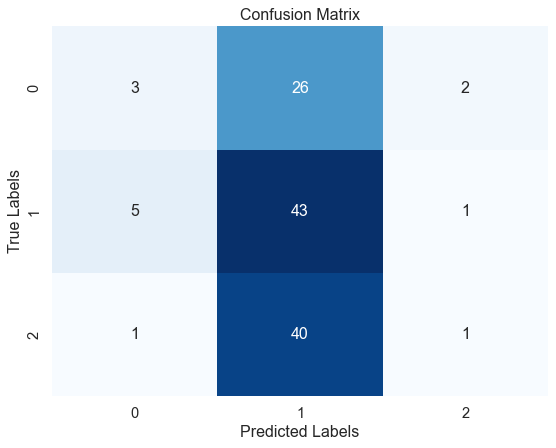

In [16]:
# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size for better visualization
sns.heatmap(cfm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

Having completed these steps, let's plot the model's predictions against the ground truth.

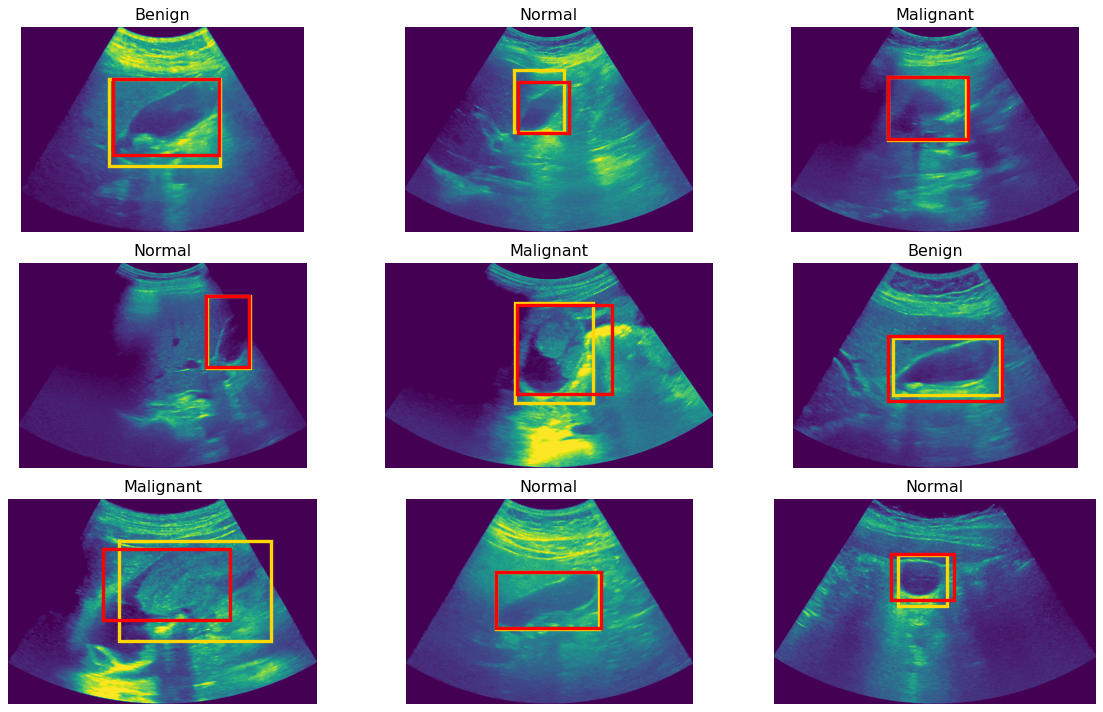

In [57]:
def plot_images_with_boxes(train_labels, df):
    plt.figure(figsize=(15, 9))
    for i in range(9):
        # Choose a random index
        random_index = random.randint(0, len(train_labels) - 1)
        img_name, img_class = train_labels[random_index][:11], train_labels[random_index][-1]

        # Load the image
        img = plt.imread('./data/imgs/' + img_name)

        # Plot the image
        plt.subplot(3, 3, i+1)
        plt.imshow(img)
        plt.title(get_class_label(int(img_class)))
        plt.axis('off')

        # Get bounding box information from df dictionary
        bbox_info = df.get(img_name)
        if bbox_info:
            # Extract ground truth bounding box coordinates
            gold_box = bbox_info['Gold']
            x_min_gt, y_min_gt, x_max_gt, y_max_gt = gold_box[0], gold_box[1], gold_box[2], gold_box[3]

            # Create a rectangle patch for ground truth
            rect_gt = patches.Rectangle((x_min_gt, y_min_gt), x_max_gt - x_min_gt, y_max_gt - y_min_gt, linewidth=3, edgecolor='gold', facecolor='none')
            # Add the ground truth patch to the Axes
            plt.gca().add_patch(rect_gt)

            # Extract predicted bounding box coordinates
            pred_boxes = bbox_info['Boxes']
            for pred_box in pred_boxes:
                x_min_pred, y_min_pred, x_max_pred, y_max_pred = pred_box[0], pred_box[1], pred_box[2], pred_box[3]

                # Create a rectangle patch for predicted bounding box
                rect_pred = patches.Rectangle((x_min_pred, y_min_pred), x_max_pred - x_min_pred, y_max_pred - y_min_pred, linewidth=3, edgecolor='red', facecolor='none')
                # Add the predicted patch to the Axes
                plt.gca().add_patch(rect_pred)

    plt.tight_layout()
    plt.show()

# Call the function to plot images with both ground truth and predicted bounding boxes
plot_images_with_boxes(train_labels, df)